# Reinforcement Learning
Now you finished the assignments working with Gym it's time for the real thing. <br>
Find a game you like and create a reinforcement agent that can play this game. <br>
This can be any game, but remember that you have to be able to access or being able to calculate the three main parameters of reinforcement learning: state, action and reward. 

In [4]:
from IPython.display import Image

## Game
The game I have chosen to solve is 2048. <br>
A Gym environment implementation is neatly provided in [DQN-2048](https://github.com/SergioIommi/DQN-2048/blob/master/game2048.py) repository.<br>
State = 4x4 array<br>
Action = Left | Up | Right | Down<br>
Reward = accumulated score until illegal move (or game over)<br>

## Q-learning?
To calculate the total q table, all possible states must be calculated. <br> 
This is done by multiplying the board size with the board size. <br>
And, then calculating each possible tile (if we limit the game to reach 2048). <br>
Starting from 2 until 2048, there are 11 unique tiles: 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048. <br>
And, ofcourse, there is a blank cell. <br>
The final equation would be total_states = unique_tiles ^ total_cells_on_board

In [1]:
total_cells_on_board = 4 * 4
unique_tiles = 11
assert 2048 == 2 ** unique_tiles, f"2048 does not have {unique_tiles} powers"
unique_tiles += 1
total_states = unique_tiles ** total_cells_on_board
print(f'Total states: {total_states:,}')

Total states: 184,884,258,895,036,416


Considering that the Q-table would be too large. <br> 
A switch to an algorithm which calculates Q-values is not a bad idea...

## Deep Q-learning!
To understand how Deep Q-learning Networks work, I have followed the tutorial: [Reinforcement Learning w/ Keras + OpenAI: DQNs](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c). <br>
I managed to get it to work with the 2048 Gym environment, but the performance was poor.

## DQN
I have tried several different hyperparameters and architectures but there was no improvement to be found.

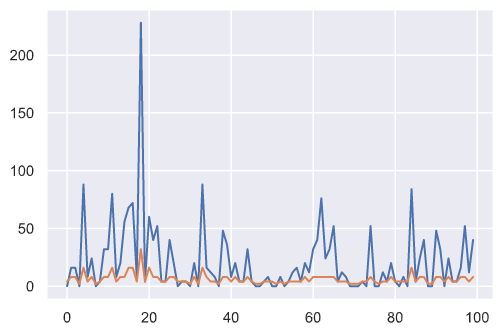

In [5]:
# X = episode, Y = game score
Image('game2048dqn.png')

## A2C
Before continueing with the 2048 game, I decided first try the famous cartpole gym environment on a different RL model. <br>
The tutorial I followed: [Deep Reinforcement Learning With Tensorflow 2.1 (A2C)](http://inoryy.com/post/tensorflow2-deep-reinforcement-learning/#asynchronous-advantage-actor-critic). <br>
This problem is considered solved when the model is able to stay above a score of 179 for more than 100 episodes concurrently. <br>
I was too eager to see it finish this problem, since I could see it clearly learn. <br>
So, I ended it early and looked into other RL models.

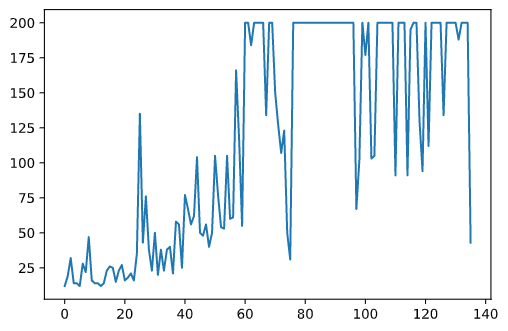

In [6]:
# X = episode, Y = score
Image('cartpolev0.png')

I also attempted this model on the 2048 game and it seemed to learn very slowly.

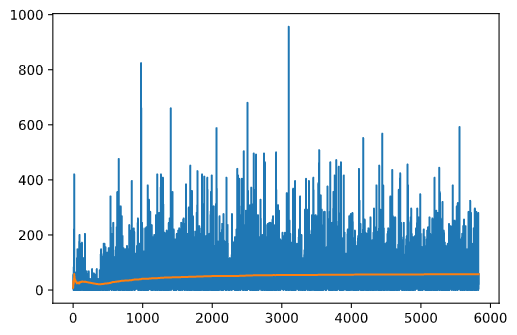

In [10]:
# X = steps, Y = score
Image('game2048A2C.png')

## A3C
During the tutorial of the A2C RL model, I discovered that there is also an asynchronous variant of this model. <br>
I found a very neat github [DeepRL-TensorFlow2](https://github.com/marload/DeepRL-TensorFlow2) repository that holds many well known deep RL algorithms which has code that is very clear. <br>
I tried several settings for the model but was not succesful in getting it to learn properly. <br>

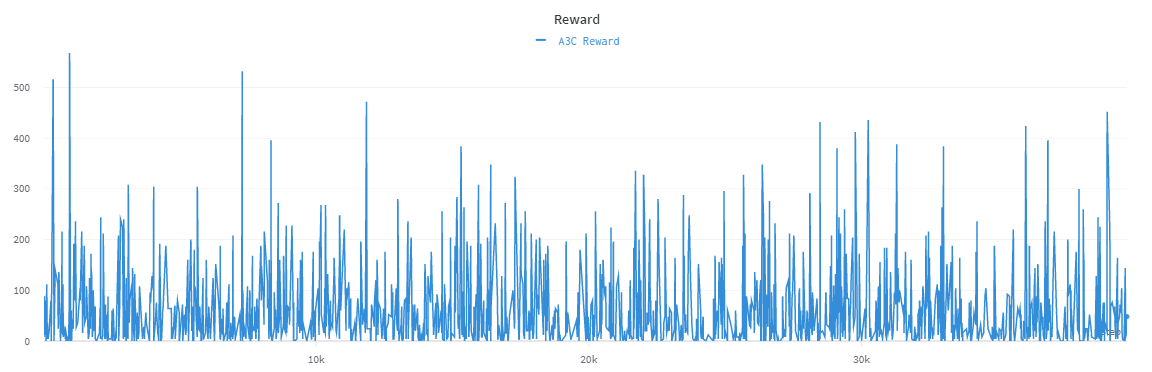

In [7]:
# X = steps, Y = score
Image('game2048A3C.png')

## DuelingDoubleDQN
In that same code repository I also found DuelingDoubleDQN. <br>
I read that this kind of algorithm is also used with AlphaGO, So I had to give it a try... <br>
I let it run overnight but unfortunately it was not able to learn at all. <br>
The loss also showed that it was really plateauing. <br>
I felt like the reward system was not good enough.

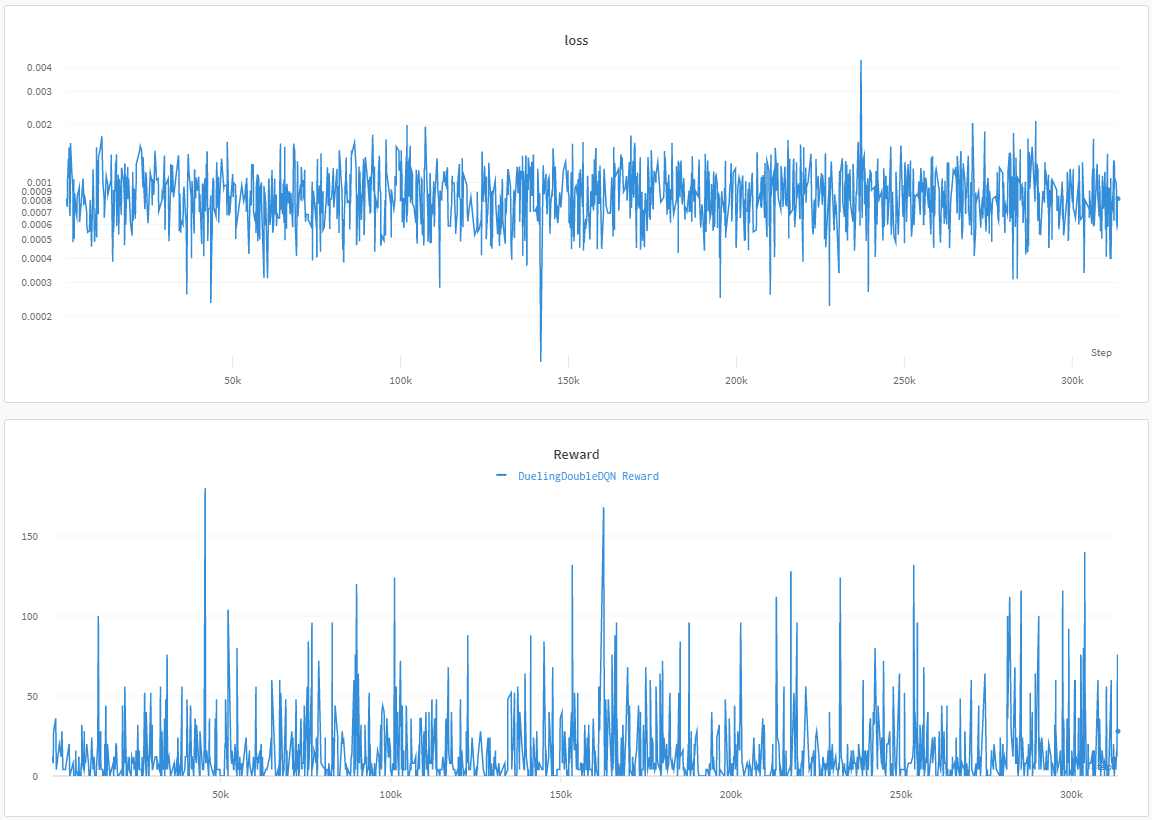

In [8]:
# X = steps, Y = score
Image('game2048dddqn0.png')

I adjusted the reward system to play complete games. <br>
And, I tried to use a different approach to the input of the models by hot encoding the gamestate.<br>
It now goes from the normal 4x4 array to 16x4x4 array. <br>
Since there are 16 powers of 2 in the game 2048.<br>
These games took a lot longer to run. <br>
The loss graph is not so promising so I decided to call it quits. <br>
I have learned a lot about RL algorithms and I am now able to apply and monitor them.

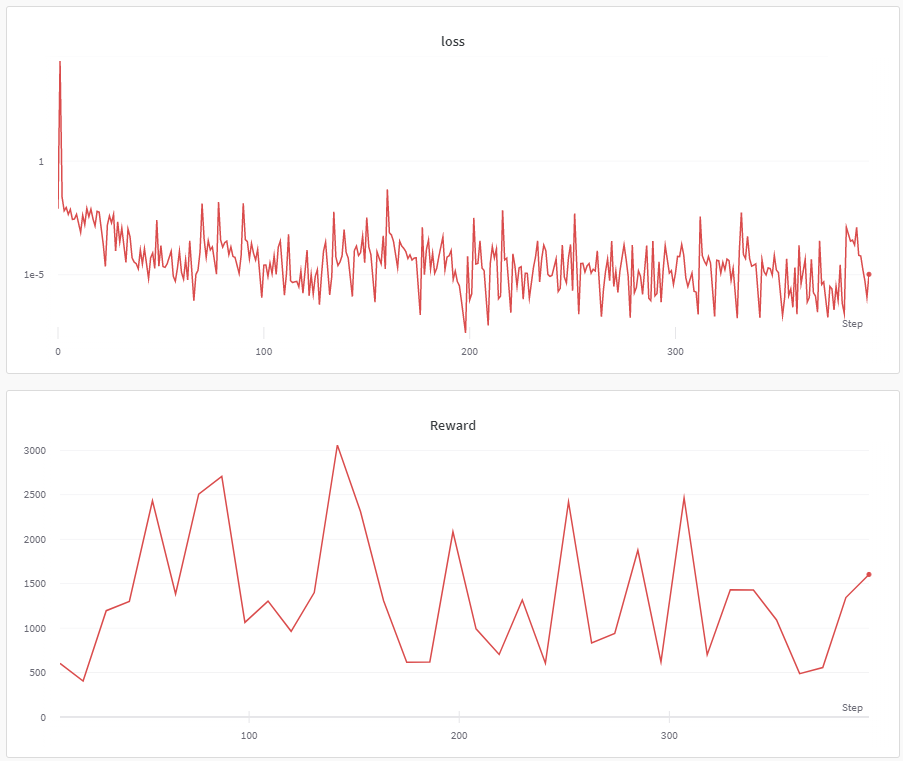

In [9]:
# X = steps, Y = score
Image('game2048dddqn1.png')

# Results
In the end, the A2C model seemed to work best for the 2048 game. <br> This gif shows the agent reaching a score of 932. <br>
I have seen it reached 1500 during testing once before. <br>
This is very impressive in the sense that these models were trained when the games stopped early if an illegal move was made.<br>
![SegmentLocal](animation.gif "segment")

## A2C Implementation
This implementation uses a CNN model and performed the best.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as kl
import tensorflow.keras.layers.experimental as kle

img_height = 280
img_width = 280
img_channels = 3

class ProbabilityDistribution(tf.keras.Model):
  def call(self, logits, **kwargs):
    # Sample a random categorical action from the given logits.
    return tf.squeeze(tf.random.categorical(logits, 1), axis=-1)

inputs = kl.Input((img_height, img_width, img_channels))
rs = kle.preprocessing.Rescaling(1./255)(inputs)
c1 = kl.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(rs)
p1 = kl.MaxPooling2D((2, 2))(c1)

c9 = kl.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
p2 = kl.MaxPooling2D((2, 2))(c9)

c2 = kl.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
p3 = kl.MaxPooling2D((2, 2))(c2)

f = kl.Flatten()(p3)
d1 = kl.Dense(128, activation='relu', kernel_initializer='he_uniform')(f)

d2 = kl.Dense(128, activation='relu')(d1)
d3 = kl.Dense(128, activation='relu')(d1)

# Logits are unnormalized log probabilities.
output_logits = kl.Dense(4, name='policy_logits')(d2)
output_value = kl.Dense(1, name='value')(d3)

dist = ProbabilityDistribution()

model = tf.keras.Model(inputs=inputs, outputs=[output_logits, output_value])

def action_value(model, dist, obs):
  logits, value = model.predict_on_batch(obs)
  action = dist.predict_on_batch(logits)
  return np.squeeze(action, axis=-1), np.squeeze(value, axis=-1)

In [2]:
import game2048_env
import gym

env = game2048_env.Game2048Env()
env.seed(0)
env.set_max_tile(2048)
env.set_illegal_move_reward(-200)

In [3]:
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko
from IPython.display import clear_output

class A2CAgent:
  def __init__(self, model, dist, lr=7e-3, gamma=0.99, value_c=0.5, entropy_c=1e-4):
    # `gamma` is the discount factor
    self.gamma = gamma
    # Coefficients are used for the loss terms.
    self.value_c = value_c
    self.entropy_c = entropy_c

    self.dist = dist
    self.model = model
    self.model.compile(
      optimizer=ko.Adam(lr=lr),
      # Define separate losses for policy logits and value estimate.
      loss=[self._logits_loss, self._value_loss])
    # self.model.load_weights('./rl_weights.h5')

  def test(self, env, render=True):
    obs, done, ep_reward = env.reset(), False, 0
    while not done:
      action, _ = self.action_value(obs)
      obs, reward, done, _ = env.step(action)
      ep_reward += reward
      if render:
        env.render()
    return ep_reward

  def _value_loss(self, returns, value):
    # Value loss is typically MSE between value estimates and returns.
    return self.value_c * kls.mean_squared_error(returns, value)

  def _logits_loss(self, actions_and_advantages, logits):
    # A trick to input actions and advantages through the same API.
    actions, advantages = tf.split(actions_and_advantages, 2, axis=-1)

    # Sparse categorical CE loss obj that supports sample_weight arg on `call()`.
    # `from_logits` argument ensures transformation into normalized probabilities.
    weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)

    # Policy loss is defined by policy gradients, weighted by advantages.
    # Note: we only calculate the loss on the actions we've actually taken.
    actions = tf.cast(actions, tf.int32)
    policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)

    # Entropy loss can be calculated as cross-entropy over itself.
    probs = tf.nn.softmax(logits)
    entropy_loss = kls.categorical_crossentropy(probs, probs)

    # We want to minimize policy and maximize entropy losses.
    # Here signs are flipped because the optimizer minimizes.
    return policy_loss - self.entropy_c * entropy_loss

  def train(self, env, batch_sz=64, updates=250):
    # Storage helpers for a single batch of data.
    actions = np.empty((batch_sz,), dtype=np.int32)
    rewards, dones, values = np.empty((3, batch_sz))
    observations = np.empty((batch_sz,) + (280,280,3))

    # Training loop: collect samples, send to optimizer, repeat updates times.
    ep_rewards = [0.0]
    next_obs = env.reset()
    for update in range(updates):
      for step in range(batch_sz):
        observations[step] = next_obs.copy()
        actions[step], values[step] = self.action_value(next_obs)
        next_obs, rewards[step], dones[step], _ = env.step(actions[step])
        ep_rewards[-1] += rewards[step]
        if dones[step]:
          ep_rewards.append(0.0)
          next_obs = env.reset()
          tf.print("Episode: %03d, Reward: %03d" % (
            len(ep_rewards) - 1, ep_rewards[-2]))

      _, next_value = self.action_value(next_obs)

      returns, advs = self._returns_advantages(rewards, dones, values, next_value)
      # A trick to input actions and advantages through same API.
      acts_and_advs = np.concatenate([actions[:, None], advs[:, None]], axis=-1)

      # Performs a full training step on the collected batch.
      # Note: no need to mess around with gradients, Keras API handles it.
      losses = self.model.train_on_batch(observations, [acts_and_advs, returns])

    return ep_rewards

  def _returns_advantages(self, rewards, dones, values, next_value):
    # `next_value` is the bootstrap value estimate of the future state (critic).
    returns = np.append(np.zeros_like(rewards), next_value, axis=-1)

    # Returns are calculated as discounted sum of future rewards.
    for t in reversed(range(rewards.shape[0])):
      returns[t] = rewards[t] + self.gamma * returns[t + 1] * (1 - dones[t])
    returns = returns[:-1]

    # Advantages are equal to returns - baseline (value estimates in our case).
    advantages = returns - values

    return returns, advantages

  def action_value(self, obs):
    logits, value = self.model.predict_on_batch(obs)
    action = self.dist.predict_on_batch(logits)
    return np.squeeze(action, axis=-1), np.squeeze(value, axis=-1)

In [4]:
agent = A2CAgent(model, dist)

In [5]:
rewards_history = agent.train(env, batch_sz=8, updates=10_000)
# print("Finished training, testing...")
# agent.test(env)

: 5092, Reward: 216
Episode: 5093, Reward: 004
Episode: 5094, Reward: 016
Episode: 5095, Reward: 084
Episode: 5096, Reward: 004
Episode: 5097, Reward: 000
Episode: 5098, Reward: 188
Episode: 5099, Reward: 124
Episode: 5100, Reward: 012
Episode: 5101, Reward: 080
Episode: 5102, Reward: 084
Episode: 5103, Reward: 048
Episode: 5104, Reward: 228
Episode: 5105, Reward: 072
Episode: 5106, Reward: 104
Episode: 5107, Reward: 064
Episode: 5108, Reward: 000
Episode: 5109, Reward: 004
Episode: 5110, Reward: 068
Episode: 5111, Reward: 000
Episode: 5112, Reward: 004
Episode: 5113, Reward: 020
Episode: 5114, Reward: 008
Episode: 5115, Reward: 004
Episode: 5116, Reward: 004
Episode: 5117, Reward: 028
Episode: 5118, Reward: 116
Episode: 5119, Reward: 000
Episode: 5120, Reward: 000
Episode: 5121, Reward: 060
Episode: 5122, Reward: 000
Episode: 5123, Reward: 032
Episode: 5124, Reward: 068
Episode: 5125, Reward: 264
Episode: 5126, Reward: 116
Episode: 5127, Reward: 024
Episode: 5128, Reward: 056
Episode:

In [13]:
env.close()

In [14]:
agent.model.save_weights('./rl_weightsv2.h5')

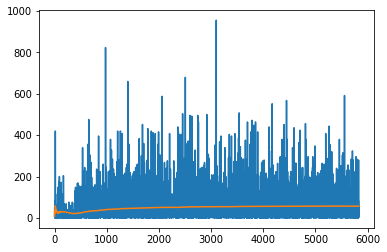

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
s = pd.Series(rewards_history)
ss = s.expanding(min_periods=1).mean()
plt.plot(s)
plt.plot(ss)

In [9]:
import PIL.Image as Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
def render_env(env, output_text, info):
    # clear_output(wait=True)
    # print(output_text)
    if info['illegal_move']:
        print("Ended because of illegal move")
    rgb = env.render('rgb_array')
    
    return Image.fromarray(rgb)
    # display(Image.fromarray(rgb))

Ended because of illegal move


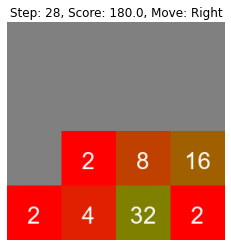

In [10]:
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rcParams['animation.ffmpeg_path'] = r'C:\ffmpeg\bin\ffmpeg.exe'

done = False
observation = env.reset()
directions = ["Up", "Right", "Down", "Left"]
step = 0
images = []
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis('off')
while not done:
    action, value = agent.model.action_value(observation)
    next_observation, reward, done, info = env.step(action)
    step += 1
    t = f"Step: {step}, Score: {env.score}, Move: {directions[action]}"
    title = plt.text(0.5,1.01,t, ha="center",va="bottom",transform=ax.transAxes, fontsize="large")
    image = render_env(env, f"Step: {step}, Score: {env.score}", info)
    im = ax.imshow(image, animated=True)
    images.append([im, title])
    observation = next_observation.copy()
ani = animation.ArtistAnimation(fig, images, blit=False, repeat_delay=2000)
ani.save('animation2.gif', fps=4)
plt.show()